# Домашнее задание 9. Настройка композиций алгоритмов

В этом задании вы настроите случайный лес, градиентный бустинг, а также их композицию на данных
соревнования [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing).

Данные загружаются сразу из гитхаба ниже.

Кратко о задаче: объекты - автомобили, целевая переменная - время, за которое автомобиль проходит тест, задача регрессии, качество измеряется с помощью $R^2$-метрики.

Скрипт загрузки и базовой предобработки данных взят с [Kaggle Kernels](https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55/notebook). В этом же ядре приводится базовый exploration данных.

## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import os
import gc
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/nadiinchi/hse_cs_ml_course_2017_FTAD/master/materials/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


Распределение целевого признака:

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


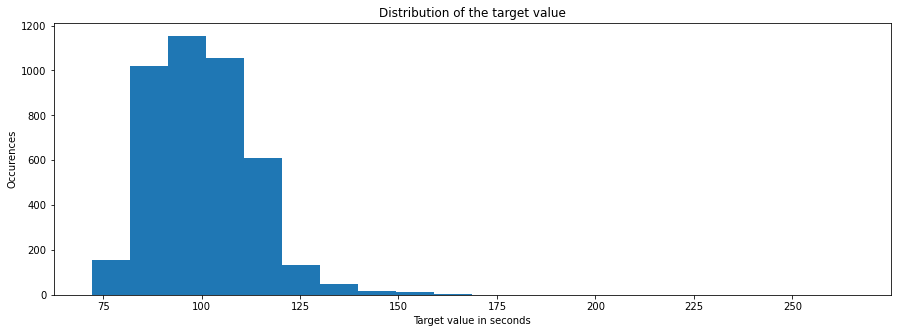

In [3]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

Число признаков и объектов:

In [4]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

Приведение данных к вещественному виду:

In [5]:
usable_columns = list(set(df_train.columns) - set(['ID', 'y']))
y_train = df_train['y'].values
x_train = df_train[usable_columns]
for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        
x_train.head()

<ipython-input-5-86fbcd4c84a1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[column] = x_train[column].apply(mapper)


,X307,X187,X282,X228,X87,X12,X91,X296,X82,X233,...,X96,X179,X152,X251,X124,X292,X361,X57,X219,X151
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0


## Разделение данных
Разделим данные на три части. Первую будем использовать для настройки случайного леса и градиентного бустинга, вторую - для настройки композиции, третью - для итогового контроля.

In [6]:
x_train.shape, y_train.shape

((4209, 376), (4209,))

In [7]:
from sklearn.utils import shuffle

In [8]:
x_train, y_train = shuffle(x_train, y_train, random_state=1)

In [9]:
x1, y1 = x_train[:2000], y_train[:2000]
x1.shape, y1.shape

((2000, 376), (2000,))

In [10]:
x2, y2 = x_train[2000:3000], y_train[2000:3000]
x2.shape, y2.shape

((1000, 376), (1000,))

In [11]:
x3, y3 = x_train[3000:], y_train[3000:]
x3.shape, y3.shape

((1209, 376), (1209,))

## Настройка моделей

На занятиях мы обсуждали, что поскольку случайный лес и градиентный бустинг разрабатывались исходя из разных принципов, то и базовые алгоритмы - решающие деревья - им нужны разные. Отсюда вытекает, что какие-то гиперапараметры более важны, а какие-то - менее важны для каждого из этих алгоритмов. Для каждого из алгоритмов мы будем сначала подбирать наиболее важные для него гиперапраметры, а затем - втоостепенные.

Для случайного леса самый важный гиперпараметр - max_features (сколько случайно выбранных признаков перебирать при построении вершины), потому что он влияет на то, насколько различными будут деревья (а это основная идея случайного леса). В частности, если вы меняете признаковое пространство (а значит, и число признаков), то этот гиперпараметр надо подбирать заново. После настройки max_features подбираются остальные гиперпараметры.

Для градиентного бустинга самые важные гиперпараметры - число деревьев и глубина дерева. Глубина дерева задает, насколько слабыми или сильными будут отдельные деревья, а значит и то, насколько мы будем двигаться в сторону градиента. После этих гиперпараметров подбирают другие гиперпараметры. 

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV

В этой части вам надо найти оптимальные гиперпараметры для случайного леса и градиентного бустинга, используя первую часть выборки (x1, y1).

__Задание 1.__
Начнем со случайного леса. 
1. (уже сделано ниже) Постройте график зависимости качества от числа деревьев в случайном лесе на кросс-валидации с 3 блоками. Выберите число деревьев для использования в дальнейшей настройке и при итоговом обучении модели.
1. __(1.25 балла)__ Постройте график зависимости качества от max_features на кросс-валидации. Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите оптимальное значение гиперпараметра.
1. __(1.25 балла)__ С помощью кросс-валидации выберите оптимальные значения для max_depth, min_samples_leaf, min_samples_split. В этом пункте не нужно строить график, только выбрать лучшее значение. Обратите внимание, что в этом пункте нужно использовать max_features, выбранное на предыдущем шаге.
1. __(0.5 балла)__ Обучите случайный лес с выбранными гиперпараметрами на всей выборке x1, y1.

Указания: verbose=3 в GridSearchCV будет выводить значения качества на каждой обучаемой модели. Рекомендуется в экспериментах зафиксировать random_state у модели. Если вы перезапускаете ядро, старайтесь не перезапускать все ячейки перебора гиперпараметров (они могут долго считаться, кроме того, могут измениться оптимальные гиперпараметры, если вы не везде зафиксировали random state), перезапускайте только те ячейки, результаты которых используются дальше. В данном блоке это только ячейка, отвечающая за последний пункт (итоговое обучение случайного леса).

Если вдруг получилось, что вы перезапустили ячейки с grid search, и у вас изменились оптимальные гиперпараметры, при этом ранее полученные гиперпараметры уже использованы ниже в ноутбуке, напишите об этом пояснение и не переделывайте другие задания.

In [13]:
param_grid = {"n_estimators":2**np.arange(10)} #  логарифмическая шкала
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)

In [14]:
gs.fit(x1, y1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1 ..................................................
[CV] ...................... n_estimators=1, score=0.153, total=   0.1s
[CV] n_estimators=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................... n_estimators=1, score=-0.664, total=   0.1s
[CV] n_estimators=1 ..................................................
[CV] ...................... n_estimators=1, score=0.100, total=   0.1s
[CV] n_estimators=1 ..................................................
[CV] ..................... n_estimators=1, score=-0.018, total=   0.1s
[CV] n_estimators=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ..................... n_estimators=1, score=-0.014, total=   0.1s
[CV] n_estimators=2 ..................................................
[CV] ...................... n_estimators=2, score=0.316, total=   0.1s
[CV] n_estimators=2 ..................................................
[CV] ...................... n_estimators=2, score=0.162, total=   0.1s
[CV] n_estimators=2 ..................................................
[CV] ...................... n_estimators=2, score=0.390, total=   0.1s
[CV] n_estimators=2 ..................................................
[CV] ...................... n_estimators=2, score=0.088, total=   0.1s
[CV] n_estimators=2 ..................................................
[CV] ...................... n_estimators=2, score=0.007, total=   0.1s
[CV] n_estimators=4 ..................................................
[CV] ...................... n_estimators=4, score=0.367, total=   0.3s
[CV] n_estimators=4 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=True),
             iid='deprecated', n_job

In [15]:
gs.best_params_

{'n_estimators': 256}

Text(0, 0.5, 'R2')

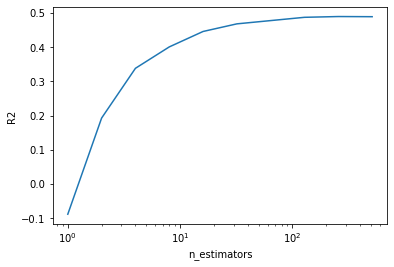

In [16]:
plt.plot((param_grid["n_estimators"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("n_estimators")
plt.ylabel("R2")

Качество, как и ожидается, растет с увеличением числа базовых алгоритмов. Для валидации выберем 100 деревьев (быстро обучается и уже более-менее принадлежит области стабильности качества), финальную модель будем обучать с 500 деревьями.

In [17]:
# базовая логарифмическая шкала для max_features
param_grid = {"max_features":2**np.arange(1, 9)}
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)

In [18]:
gs.fit(x1, y1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] max_features=2 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... max_features=2, score=0.425, total=   1.0s
[CV] max_features=2 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ...................... max_features=2, score=0.506, total=   0.9s
[CV] max_features=2 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] ...................... max_features=2, score=0.586, total=   0.9s
[CV] max_features=2 ..................................................
[CV] ...................... max_features=2, score=0.257, total=   0.8s
[CV] max_features=2 ..................................................
[CV] ...................... max_features=2, score=0.393, total=   0.8s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.439, total=   0.8s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.517, total=   0.9s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.603, total=   0.9s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.265, total=   0.9s
[CV] max_features=4 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=True),
             iid='deprecated', n_job

In [20]:
gs.best_params_

{'max_features': 32}

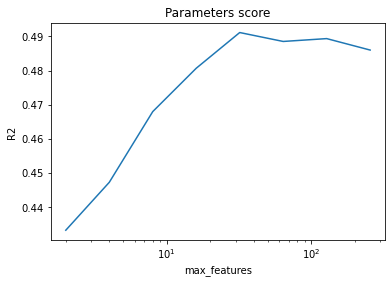

In [19]:
ax = plt.subplot()
ax.plot((param_grid["max_features"]), gs.cv_results_['mean_test_score'])
ax.set_title('Parameters score')
ax.set_xscale("log")
ax.set_xlabel("max_features")
ax.set_ylabel("R2")
plt.show()

Параметр `max_features` отвечает за количество *фич*, которые следует учитывать при поиске лучшего разделения. Этот механизм используется для контроля переобучения. При больших значениях, в нашем случае, происходит недообучение. Практически невозможно вычислить без подбора какое количество `max_features` нам необходимо, но в данном случае когда мы берем 32 или 512 фич из 2000 соответственно мы получаем низкие результаты. Поэтому логично ожидать лучший результат когда мы берем не очень большое число `max_features`

In [21]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_depth":np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], "min_samples_split":[3, 9, 27, 81]}
gs = GridSearchCV(RandomForestRegressor(max_features=32, random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)

In [22]:
gs.fit(x1,y1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.248, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.306, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.293, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.158, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.251, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.248, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.306, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.293, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_s

[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=27, score=0.251, total=   0.3s
[CV] max_depth=1, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=81, score=0.248, total=   0.3s
[CV] max_depth=1, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=81, score=0.306, total=   0.3s
[CV] max_depth=1, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=81, score=0.293, total=   0.3s
[CV] max_depth=1, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=81, score=0.158, total=   0.3s
[CV] max_depth=1, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=81, score=0.251, total=   0.3s
[CV] max_depth=1, min_samples_leaf=27, min_samples_split=3 ...........
[CV]  max_depth=1, min_samples_leaf=27, min_sa

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=9, score=0.538, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=9, score=0.567, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=9, score=0.287, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=9, score=0.453, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=27, score=0.433, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=27, score=0.545, total=   0.3s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples

[CV]  max_depth=3, min_samples_leaf=27, min_samples_split=81, score=0.282, total=   0.3s
[CV] max_depth=3, min_samples_leaf=27, min_samples_split=81 ..........
[CV]  max_depth=3, min_samples_leaf=27, min_samples_split=81, score=0.449, total=   0.3s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, score=0.496, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, score=0.617, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, score=0.667, total=   0.5s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, score=0.340, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=1, min_sampl

[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=27, score=0.496, total=   0.4s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=27 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=27, score=0.612, total=   0.4s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=27 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=27, score=0.669, total=   0.4s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=27 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=27, score=0.327, total=   0.4s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=27 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=27, score=0.509, total=   0.4s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=81, score=0.492, total=   0.4s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_sam

[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, score=0.687, total=   0.5s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, score=0.351, total=   0.5s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, score=0.522, total=   0.4s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=9, score=0.517, total=   0.5s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=9, score=0.630, total=   0.4s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=9, score=0.681, total=   0.4s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_s

[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=27, score=0.512, total=   0.4s
[CV] max_depth=7, min_samples_leaf=27, min_samples_split=81 ..........
[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=81, score=0.492, total=   0.4s
[CV] max_depth=7, min_samples_leaf=27, min_samples_split=81 ..........
[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=81, score=0.610, total=   0.4s
[CV] max_depth=7, min_samples_leaf=27, min_samples_split=81 ..........
[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=81, score=0.657, total=   0.4s
[CV] max_depth=7, min_samples_leaf=27, min_samples_split=81 ..........
[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=81, score=0.335, total=   0.4s
[CV] max_depth=7, min_samples_leaf=27, min_samples_split=81 ..........
[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=81, score=0.512, total=   0.4s


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  1.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features=32,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=True),
             iid='deprecated', n_jobs=No

In [23]:
gs.best_params_

{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 27}

In [28]:
RF_hp = RandomForestRegressor(n_estimators = 500,
                              max_features = 32,
                              max_depth = 7,
                              min_samples_leaf = 1,
                              min_samples_split = 27,
                              random_state = 1,
                              warm_start = True
)
RF_hp.fit(x1, y1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features=32, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=27, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=True)

In [29]:
RF_hp.score(x1, y1)

0.5709316091911154

__Задание 2.__

Теперь настроим градиентный бустинг, используя ту же выборку x1, y1.

1.  __(1.5 балла)__ Запустите кросс-валидацию для GradientBoostingRegressor по n_estimators и learning_rate. Постройте двумерный график или несколько одномерных (например, график качество-число деревьев при разных значениях длины шага). При построении графиков используйте логарифмическую шкалу по оси абсцисс (вызовите np.log2 или используйте plt.xscale("log")). Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите значения для использования при дальнейшей настройке и для финального обучения модели.
1.  __(1.25 балла)__ Постройте график зависимости качества от max_depth на кросс-валидации. Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите оптимальное значение гиперпараметра.
1.  __(1.25 балла)__ Выберите оптимальные значения для min_samples_split, min_samples_leaf, max_features с помощью кросс-валидации. В этом пункте не нужно строить график. Обратите внимание, что в этом пункте нужно исползьзовать ранее выбранные гиперпараметры.
1.  __(0.5 балла)__ Обучите итоговую модель с выбранными значениями гиперпараметров на всей выборке x1, y1.

Примеры построения трехмерных графиков [здесь](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html).

In [24]:
# базовая шкала для числа деревьев и длины шага
param_grid = {"n_estimators":2**np.arange(10), "learning_rate":0.1**np.arange(5)}
gs = GridSearchCV(GradientBoostingRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)

In [25]:
gs.fit(x1,y1)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.524, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.627, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.702, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.381, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.488, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ... learning_rate=1.0, n_estimators=2, score=0.528, total=   0.1s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ... learning_rate=1.0, n_estimators=2, score=0.627, total=   0.1s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ... learning_rate=1.0, n_estimators=2, score=0.680, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ... learning_rate=1.0, n_estimators=2, score=0.368, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ... learning_rate=1.0, n_estimators=2, score=0.492, total=   0.0s
[CV] learning_rate=1.0, n_estimators=4 ...............................
[CV] ... learning_rate=1.0, n_estimators=4, score=0.527, total=   0.1s
[CV] learning_rate=1.0, n_estimators=4 ...............................
[CV] ... learning_rate=1.0, n_estimators=4, score=0.617, total=   0.1s
[CV] learning_rate=1.0, n_estimators=4 ...............................
[CV] .

[CV] ... learning_rate=0.1, n_estimators=4, score=0.221, total=   0.1s
[CV] learning_rate=0.1, n_estimators=4 ...............................
[CV] ... learning_rate=0.1, n_estimators=4, score=0.314, total=   0.1s
[CV] learning_rate=0.1, n_estimators=8 ...............................
[CV] ... learning_rate=0.1, n_estimators=8, score=0.420, total=   0.1s
[CV] learning_rate=0.1, n_estimators=8 ...............................
[CV] ... learning_rate=0.1, n_estimators=8, score=0.515, total=   0.1s
[CV] learning_rate=0.1, n_estimators=8 ...............................
[CV] ... learning_rate=0.1, n_estimators=8, score=0.573, total=   0.1s
[CV] learning_rate=0.1, n_estimators=8 ...............................
[CV] ... learning_rate=0.1, n_estimators=8, score=0.316, total=   0.1s
[CV] learning_rate=0.1, n_estimators=8 ...............................
[CV] ... learning_rate=0.1, n_estimators=8, score=0.441, total=   0.1s
[CV] learning_rate=0.1, n_estimators=16 ..............................
[CV] .

[CV]  learning_rate=0.010000000000000002, n_estimators=8, score=0.083, total=   0.1s
[CV] learning_rate=0.010000000000000002, n_estimators=16 .............
[CV]  learning_rate=0.010000000000000002, n_estimators=16, score=0.139, total=   0.2s
[CV] learning_rate=0.010000000000000002, n_estimators=16 .............
[CV]  learning_rate=0.010000000000000002, n_estimators=16, score=0.172, total=   0.2s
[CV] learning_rate=0.010000000000000002, n_estimators=16 .............
[CV]  learning_rate=0.010000000000000002, n_estimators=16, score=0.191, total=   0.2s
[CV] learning_rate=0.010000000000000002, n_estimators=16 .............
[CV]  learning_rate=0.010000000000000002, n_estimators=16, score=0.105, total=   0.2s
[CV] learning_rate=0.010000000000000002, n_estimators=16 .............
[CV]  learning_rate=0.010000000000000002, n_estimators=16, score=0.154, total=   0.2s
[CV] learning_rate=0.010000000000000002, n_estimators=32 .............
[CV]  learning_rate=0.010000000000000002, n_estimators=32, 

[CV]  learning_rate=0.0010000000000000002, n_estimators=16, score=0.018, total=   0.2s
[CV] learning_rate=0.0010000000000000002, n_estimators=16 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=16, score=0.009, total=   0.2s
[CV] learning_rate=0.0010000000000000002, n_estimators=16 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=16, score=0.017, total=   0.2s
[CV] learning_rate=0.0010000000000000002, n_estimators=32 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=32, score=0.031, total=   0.5s
[CV] learning_rate=0.0010000000000000002, n_estimators=32 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=32, score=0.038, total=   0.4s
[CV] learning_rate=0.0010000000000000002, n_estimators=32 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=32, score=0.040, total=   0.5s
[CV] learning_rate=0.0010000000000000002, n_estimators=32 ............
[CV]  learning_rate=0.0010000000000000002, n_estimat

[CV]  learning_rate=0.00010000000000000002, n_estimators=16, score=0.001, total=   0.2s
[CV] learning_rate=0.00010000000000000002, n_estimators=32 ...........
[CV]  learning_rate=0.00010000000000000002, n_estimators=32, score=0.003, total=   0.5s
[CV] learning_rate=0.00010000000000000002, n_estimators=32 ...........
[CV]  learning_rate=0.00010000000000000002, n_estimators=32, score=0.003, total=   0.4s
[CV] learning_rate=0.00010000000000000002, n_estimators=32 ...........
[CV]  learning_rate=0.00010000000000000002, n_estimators=32, score=0.001, total=   0.4s
[CV] learning_rate=0.00010000000000000002, n_estimators=32 ...........
[CV]  learning_rate=0.00010000000000000002, n_estimators=32, score=-0.000, total=   0.4s
[CV] learning_rate=0.00010000000000000002, n_estimators=32 ...........
[CV]  learning_rate=0.00010000000000000002, n_estimators=32, score=0.003, total=   0.4s
[CV] learning_rate=0.00010000000000000002, n_estimators=64 ...........
[CV]  learning_rate=0.00010000000000000002, n

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  5.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                            

In [26]:
gs.best_params_

{'learning_rate': 0.010000000000000002, 'n_estimators': 512}

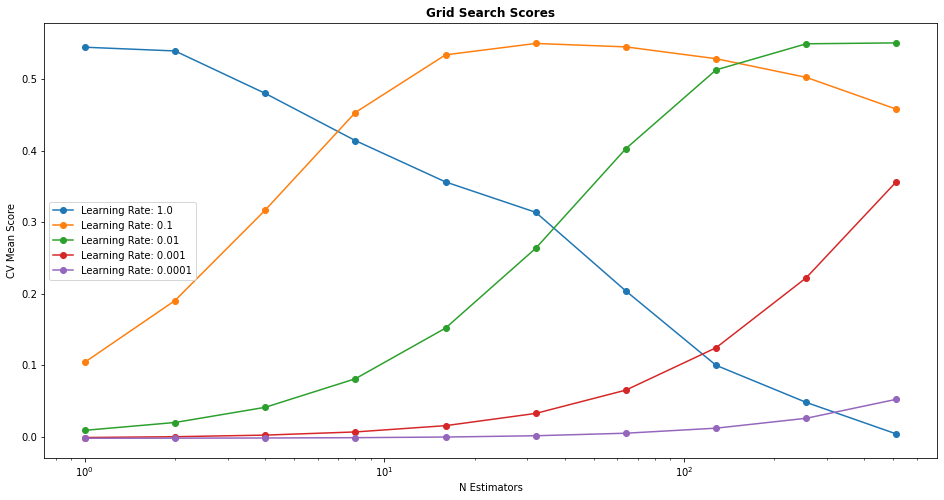

In [30]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    
    # Получим результат среднего и стандартного отклонения для каждой итерации grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))

    # Отобразим на графике
    _, ax = plt.subplots()

    rounded_grid_param_2 = [np.round(x,4) for x in grid_param_2]
    for idx, val in enumerate(rounded_grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label = name_param_2 + ': ' + str(val))
    plt.rcParams['figure.figsize'] = (20, 14)
    ax.set_title("Grid Search Scores", fontweight='bold')
    ax.set_xlabel(name_param_1)
    ax.set_xscale("log")
    ax.set_ylabel('CV Mean Score')
    ax.legend(loc="best")

# Calling Method 
plot_grid_search(gs.cv_results_, param_grid["n_estimators"], param_grid["learning_rate"], 'N Estimators', 'Learning Rate')

`learning_rate` регулирует вклад каждого дерева. Существует связь между learning_rate и n_estimators. Рассмотрим лучший результат, то есть когда  learning_rate = 0.01 и n_estimators = 512, при малых количествах деревьев происходит недообучение. Поведение ожидаемое

In [31]:
# базовая шкала для max_depth
param_grid = {"max_depth":np.arange(1, 9)}
gs = GridSearchCV(GradientBoostingRegressor(learning_rate = 0.01,
                                            n_estimators = 512, 
                                            random_state=1, 
                                            warm_start=True), 
                  param_grid, make_scorer(r2_score), verbose=3)

In [32]:
gs.fit(x1,y1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... max_depth=1, score=0.486, total=   2.8s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ......................... max_depth=1, score=0.591, total=   3.0s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s


[CV] ......................... max_depth=1, score=0.649, total=   2.9s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.340, total=   2.9s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.493, total=   3.0s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.529, total=   5.0s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.644, total=   5.2s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.702, total=   4.9s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.376, total=   4.9s
[CV] max_depth=2 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  7.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.01,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=512,
                                                 n_iter_no_change=None,
             

In [33]:
gs.best_params_

{'max_depth': 2}

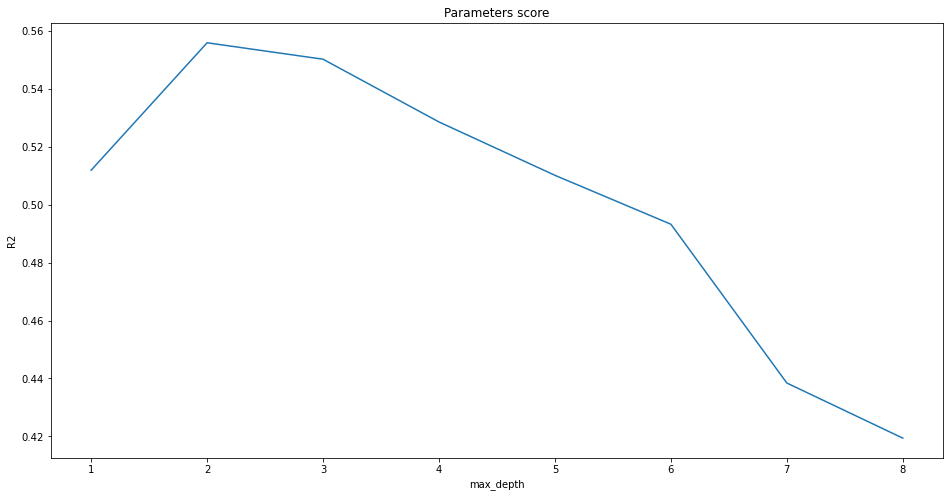

In [36]:
ax = plt.subplot()
plt.rcParams['figure.figsize'] = (12, 6)
ax.plot((param_grid["max_depth"]), gs.cv_results_['mean_test_score'])
ax.set_title('Parameters score')
ax.set_xlabel("max_depth")
ax.set_ylabel("R2")
plt.show()

`max_depth` это максимальная глубина индивидуальных регрессионных оценок. Максимальная глубина ограничивает количество узлов в дереве. Наилучшее значение зависит от природы входных переменных. При слишком большой глубине происходит недообучение. Результат ожидаемый. Значение по умолчанию - 3

In [37]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_features":2**np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], 
              "min_samples_split":[3, 9, 27, 81]}
gs = GridSearchCV(GradientBoostingRegressor(learning_rate = 0.01,
                                            n_estimators = 512,
                                            max_depth = 2, 
                                            random_state=1, 
                                            warm_start=True), 
                  param_grid, make_scorer(r2_score), verbose=3)

In [38]:
gs.fit(x1,y1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.300, total=   0.3s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.373, total=   0.3s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.403, total=   0.3s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.199, total=   0.3s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.302, total=   0.4s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.300, total=   0.3s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.373, total=   0.3s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.403, total=   0.3s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_

[CV]  max_features=2, min_samples_leaf=9, min_samples_split=27, score=0.199, total=   0.3s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=27 ........
[CV]  max_features=2, min_samples_leaf=9, min_samples_split=27, score=0.300, total=   0.4s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=81 ........
[CV]  max_features=2, min_samples_leaf=9, min_samples_split=81, score=0.294, total=   0.4s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=81 ........
[CV]  max_features=2, min_samples_leaf=9, min_samples_split=81, score=0.358, total=   0.3s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=81 ........
[CV]  max_features=2, min_samples_leaf=9, min_samples_split=81, score=0.393, total=   0.3s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=81 ........
[CV]  max_features=2, min_samples_leaf=9, min_samples_split=81, score=0.196, total=   0.3s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=81 ........
[CV]  max_features=2, min_sa

[CV]  max_features=8, min_samples_leaf=3, min_samples_split=3, score=0.445, total=   0.5s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=3, min_samples_split=9, score=0.439, total=   0.5s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=3, min_samples_split=9, score=0.543, total=   0.4s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=3, min_samples_split=9, score=0.595, total=   0.4s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=3, min_samples_split=9, score=0.293, total=   0.5s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=3, min_samples_split=9, score=0.445, total=   0.5s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=27 ........
[CV]  max_features=8, min_samples_

[CV]  max_features=8, min_samples_leaf=27, min_samples_split=81, score=0.434, total=   0.4s
[CV] max_features=8, min_samples_leaf=27, min_samples_split=81 .......
[CV]  max_features=8, min_samples_leaf=27, min_samples_split=81, score=0.535, total=   0.5s
[CV] max_features=8, min_samples_leaf=27, min_samples_split=81 .......
[CV]  max_features=8, min_samples_leaf=27, min_samples_split=81, score=0.590, total=   0.4s
[CV] max_features=8, min_samples_leaf=27, min_samples_split=81 .......
[CV]  max_features=8, min_samples_leaf=27, min_samples_split=81, score=0.289, total=   0.4s
[CV] max_features=8, min_samples_leaf=27, min_samples_split=81 .......
[CV]  max_features=8, min_samples_leaf=27, min_samples_split=81, score=0.441, total=   0.4s
[CV] max_features=32, min_samples_leaf=1, min_samples_split=3 ........
[CV]  max_features=32, min_samples_leaf=1, min_samples_split=3, score=0.516, total=   0.7s
[CV] max_features=32, min_samples_leaf=1, min_samples_split=3 ........
[CV]  max_features=32, 

[CV]  max_features=32, min_samples_leaf=9, min_samples_split=9, score=0.633, total=   0.7s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=9 ........
[CV]  max_features=32, min_samples_leaf=9, min_samples_split=9, score=0.688, total=   0.7s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=9 ........
[CV]  max_features=32, min_samples_leaf=9, min_samples_split=9, score=0.356, total=   0.7s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=9 ........
[CV]  max_features=32, min_samples_leaf=9, min_samples_split=9, score=0.528, total=   0.7s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=27 .......
[CV]  max_features=32, min_samples_leaf=9, min_samples_split=27, score=0.518, total=   0.7s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=27 .......
[CV]  max_features=32, min_samples_leaf=9, min_samples_split=27, score=0.633, total=   0.7s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=27 .......
[CV]  max_features=32, min

[CV]  max_features=128, min_samples_leaf=1, min_samples_split=81, score=0.703, total=   1.9s
[CV] max_features=128, min_samples_leaf=1, min_samples_split=81 ......
[CV]  max_features=128, min_samples_leaf=1, min_samples_split=81, score=0.374, total=   1.9s
[CV] max_features=128, min_samples_leaf=1, min_samples_split=81 ......
[CV]  max_features=128, min_samples_leaf=1, min_samples_split=81, score=0.532, total=   1.9s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=3 .......
[CV]  max_features=128, min_samples_leaf=3, min_samples_split=3, score=0.529, total=   1.9s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=3 .......
[CV]  max_features=128, min_samples_leaf=3, min_samples_split=3, score=0.647, total=   1.9s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=3 .......
[CV]  max_features=128, min_samples_leaf=3, min_samples_split=3, score=0.703, total=   1.9s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=3 .......
[CV]  max_features=

[CV]  max_features=128, min_samples_leaf=27, min_samples_split=9, score=0.372, total=   2.1s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=9 ......
[CV]  max_features=128, min_samples_leaf=27, min_samples_split=9, score=0.530, total=   2.1s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=27 .....
[CV]  max_features=128, min_samples_leaf=27, min_samples_split=27, score=0.531, total=   2.6s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=27 .....
[CV]  max_features=128, min_samples_leaf=27, min_samples_split=27, score=0.645, total=   2.1s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=27 .....
[CV]  max_features=128, min_samples_leaf=27, min_samples_split=27, score=0.703, total=   2.1s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=27 .....
[CV]  max_features=128, min_samples_leaf=27, min_samples_split=27, score=0.372, total=   2.1s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=27 .....
[CV]  max_fe

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  4.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.01,
                                                 loss='ls', max_depth=2,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=512,
                                                 n_it...
                            

In [39]:
gs.best_params_

{'max_features': 128, 'min_samples_leaf': 9, 'min_samples_split': 81}

In [40]:
GBR_hp = GradientBoostingRegressor(learning_rate = 0.01,
                                   n_estimators = 512,
                                   max_depth = 2,
                                   max_features = 128,
                                   min_samples_leaf = 9,
                                   min_samples_split = 81,
                                   random_state=1,
                                   warm_start = True
)
GBR_hp.fit(x1, y1)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=2,
                          max_features=128, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=81,
                          min_weight_fraction_leaf=0.0, n_estimators=512,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=True)

In [41]:
GBR_hp.score(x1,y1)

0.5504018138108344

__Задание 3.__

 __(1 балл)__ Выведите качество случайного леса и градиентного бустинга на x2, y2, а также качество модели, представляющей собой усреднение предсказаний двух обученных моделей. Какой из трех вариантов работает лучше?

In [42]:
RF_hp.score(x2,y2)

0.551049792790673

In [43]:
GBR_hp.score(x2,y2)

0.5615161936281889

In [44]:
models = [RF_hp, GBR_hp]

In [45]:
def averaging(models, x2, y2):
    y_pred1 = models[0].predict(x2)
    y_pred2 = models[1].predict(x2)
    y = np.stack((y_pred1, y_pred2))
    y_avg = np.mean(y, axis = 0)

    return y_avg

In [46]:
averaging(models, x2,y2)

array([111.33769657, 111.78263039,  95.39298932, 111.78266823,
        93.45391694,  94.40700563,  94.28809751,  94.28809751,
       102.95384713,  94.34715012, 111.97978924,  95.52937013,
       103.40659876,  78.41483048,  93.79909791,  93.58019313,
       111.82039132, 111.6390662 , 104.80924818,  94.63949567,
       111.55722457,  93.94135038, 103.31107992,  94.07534357,
       104.76793017, 116.01258523, 104.13525758, 103.65904777,
        94.78847069,  94.57588113,  94.46069628,  94.34787074,
       103.96129694, 111.48250262, 111.36671047, 103.72001913,
       113.41594261, 113.90333838, 102.96187185,  93.47107966,
       111.07856067, 103.18596234,  95.11333834, 102.89950257,
        95.10715469, 104.64250313,  93.78382098,  94.76862711,
        93.92089528, 110.75548146,  94.14852549,  94.93758267,
        94.39058772, 111.46002049, 111.66282791, 103.3827291 ,
        78.67674294, 102.9530083 , 111.38454853, 109.85802159,
        94.84655072,  95.56983786,  94.42944411,  95.49

In [48]:
from sklearn.metrics import mean_squared_error

In [49]:
print(f"Random forest \nMSE score: {mean_squared_error(y2, models[0].predict(x2))} \nR^2 score: {r2_score(y2, models[0].predict(x2))}")

Random forest 
MSE score: 72.23071484197598 
R^2 score: 0.551049792790673


In [50]:
print(f"Gradient Boosting \nMSE score: {mean_squared_error(y2, models[1].predict(x2))} \nR^2 score: {r2_score(y2, models[1].predict(x2))}")

Gradient Boosting 
MSE score: 70.54679621987376 
R^2 score: 0.5615161936281889


In [51]:
print(f"Averaging \nMSE score: {mean_squared_error(y2, averaging(models, x2,y2))} \nR^2 score: {r2_score(y2, averaging(models, x2,y2))}")

Averaging 
MSE score: 71.11616718240525 
R^2 score: 0.5579772668410635


Модель основанная на градиентном бустинге дает лучший результат

__Задание 4.__

 __(1 балл)__  Реализуйте блендинг. Обучите линейную регрессию на признаках - выходах двух моделей по выборке x2, y2. 

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
dataset_blend_train = np.vstack((models[0].predict(x2), models[1].predict(x2))).T

LR = LinearRegression()
LR.fit(dataset_blend_train, y2)
score = LR.score(dataset_blend_train, y2)

print(f"Blending with score {score}")

Blending with score 0.5649417595888018


__Задание 5.__

 __(0.5 балла)__ Выведите качество случайного леса и градиентного бустинга на x3, y3, качество модели, представляющей собой усреднение предсказаний двух обученных моделей, а также качество блендинга. Какая из четырех моделей работает лучше? Работает ли блендинг лучше усреднения? Выведите веса блендинга, какой из базовых алгоритмов вносит большой вклад в итоговую модель?

In [54]:
print(f"Random forest R^2 score: {RF_hp.score(x3,y3)}")

Random forest R^2 score: 0.6055414344095642


In [55]:
print(f"Gradient Boosting R^2 score: {GBR_hp.score(x3,y3)}")

Gradient Boosting R^2 score: 0.6145069458969973


In [56]:
print(f"Averaging R^2 score: {r2_score(y3, averaging(models, x3, y3))}")

Averaging R^2 score: 0.6116955259993455


In [57]:
y3_pred1 = models[0].predict(x3)
y3_pred2 = models[1].predict(x3)
dataset_blend_train = np.vstack((y3_pred1, y3_pred2)).T

LR = LinearRegression()
LR.fit(dataset_blend_train, y3)
score = LR.score(dataset_blend_train, y3)

print(f"Blending with score {score}")

Blending with score 0.6187554649081977


Модель основанная на блендинге работает лучше всех, в этом и есть вся суть блендинга - объединение нескольких моделей и обучение на их признаках новой модели.
Вообще, для повышения качества надо усреднить несколько блендингов с разными разбиениями обучения, но в нашем случае мы не затрагиваем такие более сложные механизмы. Алгоритм GradientBoostingRegressor вносит самый больший вклад в итоговый результат блендинга так как выражает лучший результат среди прочих.